In [1]:
import tensorflow as tf
import pathlib
import numpy as np
from PIL import Image
import pandas as pd
import time
from matplotlib import pyplot as plt
import cv2

2022-12-02 13:39:45.125201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 13:39:45.378667: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-02 13:39:45.378699: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-02 13:39:46.856395: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
# Load a model 
model_dir = './models/ssd_mobilenet_v1_coco_2018_01_28/saved_model/'
# model_dir = './models/faster_rcnn_resnet101_coco_2018_01_28/saved_model/'

In [11]:
model = tf.saved_model.load(str(model_dir))
model_fn = model.signatures['serving_default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Metal device set to: Apple M1 Pro


2022-12-01 16:47:51.454771: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-01 16:47:51.455628: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-01 16:47:51.490777: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-01 16:47:51.509168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [12]:
def detectPersons(image_np,model_fn):
    start = time.time()
    image = np.asarray(image_np)
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis,...]
    output_dict = model_fn(input_tensor)
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                    for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections
    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    op = {
        'classes':output_dict['detection_classes'].tolist(),
        'boxes':output_dict['detection_boxes'].tolist(),
        'scores':output_dict['detection_scores'].tolist()
    }
    op = pd.DataFrame(op)
    op = op[op['classes']==1]
    end = time.time()
    return op,end-start

In [13]:
image_np = np.array(Image.open('./dataset/960x0.jpg'))

In [14]:
detections, time_taken = detectPersons(image_np,model_fn)

2022-12-01 16:47:56.970914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [15]:
time_taken

4.959591865539551

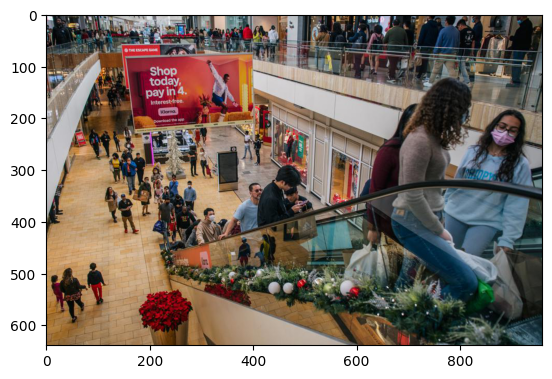

In [37]:
plt.imshow(image_np)

In [86]:
def get_normal_coord(decimal_coords,im_height,im_width):
    ymin, xmin, ymax, xmax = decimal_coords
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    return [int(left),int(right),int(top),int(bottom)]

In [66]:
im_height,im_width,_ = image_np.shape


In [87]:
 get_normal_coord(detections.iloc[0]['boxes'],im_height,im_width)


[765, 951, 177, 503]

(765.0064064860344, 951.2376131415367, 177.73561692237854, 503.42283368110657)

In [82]:
image = image_np.copy()

In [83]:
image = cv2.circle(image, (int(left),int(top)), 10, (255,255,0), 3)
image = cv2.circle(image, (int(right),int(bottom)), 10, (255,255,0), 3)
image = cv2.rectangle(image, (int(left),int(top)), (int(right),int(bottom)), (0,0,255), 2)

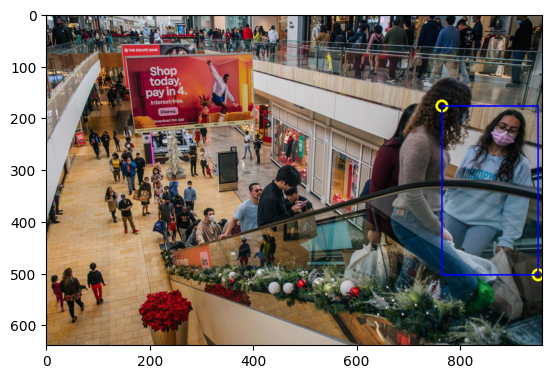

In [84]:
plt.imshow(image)